# Hand_Passward

![img](./data/image/123.jpg)

## 데이터 셋 만들기

In [9]:
import cv2
import mediapipe as mp
import numpy as np
import time, os

### 학습시킬 데이터 지정

In [10]:
actions = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
seq_length = 30 # window의 사이즈
secs_for_action = 30 # 하나의 제스쳐를 찍는데 걸리는 시간
SAVE_PATH = "./data/dataset_HPW"

### 초기화

In [11]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 1, # 몇 개의 손을 인식할 것인지
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)


### 데이터셋 저장

In [14]:
# 웹캠 열기
cap = cv2.VideoCapture(0)

created_time = int(time.time())
os.makedirs(SAVE_PATH, exist_ok=True) # 데이터 셋을 저장할 폴더 만들기

# 웹캠을 열어서 데이터 모으기
while cap.isOpened():
    for idx, action in enumerate(actions):
        data = []

        # 이미지 읽기
        ret, img = cap.read()

        # flip, 웹캠 이미지가 거울처럼 나타나기 때문
        img = cv2.flip(img, 1)

        # 어떤 제스쳐를 학습시킬 것인지 표시
        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10,30),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=2)
        
        #3초동안 대기
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()
        
        #30초동안 촬영
        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 기본적으로 BGR로 영상을 읽기 때문에 RGB로 바꿔야 함
            result = hands.process(img) # RGB로 바꾼 데이터를 result에 저장
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21,4))
                    for j,lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility] # 각 점의 x, y, z 좌표 & 점이 이미지 상에서 보이는지 안 보이는지

                    # 점들 간의 각도 계산하기
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # v2와 v1 사이의 벡터 구하기

                    # 벡터 정규화 시키기(단위 벡터 구하기)
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # 점곱을 구한 다음 arccos으로 각도 구하기
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # 라디안을 각도로 바꾸기

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx) # 라벨 추가

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS) # 랜드마크 그리기
            
            org = (50,50)
            text = f'{action}'
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, text, org, font, 1, (255,255,255),2)

            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join(SAVE_PATH, f'raw_{action}_{created_time}'),data)

        # 시퀀스 데이터로 변환
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join(SAVE_PATH, f'seq_{action}_{created_time}'), full_seq_data)
    break

cap.release()
cv2.destroyAllWindows()

0 (317, 100)
0 (287, 30, 100)
1 (0,)
1 (0,)
2 (0,)
2 (0,)
3 (0,)
3 (0,)
4 (0,)
4 (0,)
5 (0,)
5 (0,)
6 (0,)
6 (0,)
7 (0,)
7 (0,)
8 (0,)
8 (0,)
9 (0,)
9 (0,)


## 모델 훈련

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
actions = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]

### 데이터 셋을 불러오는 함수

In [3]:
def load_dataset(actions):
    data = np.concatenate([
        np.load(f"./data/dataset_HPW/seq_{action}_1689295505.npy") for action in actions
    ], axis = 0)
    
    return data

In [4]:
load_dataset(actions).shape

(8709, 30, 100)

### 데이터 전처리

In [5]:
def split_data(dataset):

    # data의 마지막 값이 라벨이므로 x_data와 labels로 나누기
    x_data = dataset[:, :, :-1]
    labels = dataset[:, 0, -1]

    # One-hot encoding 진행
    y_data = to_categorical(labels, num_classes=len(actions))

    x_data = x_data.astype(np.float32)
    y_data = y_data.astype(np.float32)

    # 학습용, 검증용 데이터 나누기
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

    return x_train, x_val, y_train, y_val

In [6]:
x_train, x_val, y_train, y_val = split_data(load_dataset(actions))

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7838, 30, 99) (7838, 10)
(871, 30, 99) (871, 10)


### 모델 구현

In [7]:
model = Sequential([
    # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), 
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 44,394
Trainable params: 44,394
Non-trainable params: 0
_________________________________________________________________


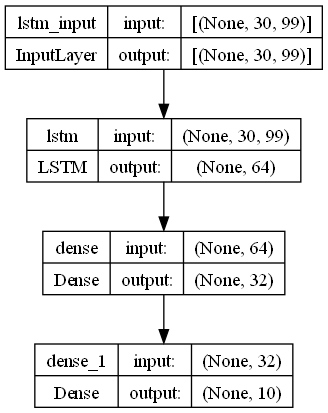

In [8]:
plot_model(model, show_shapes=True, to_file='./data/HandWard_model.png')

### 모델 학습

In [29]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('./model/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
238/245 [============================>.] - ETA: 0s - loss: 1.7912 - acc: 0.7999
Epoch 1: val_acc improved from -inf to 0.99082, saving model to ./model\model.h5
245/245 [==============================] - 3s 7ms/step - loss: 1.7423 - acc: 0.8051 - val_loss: 0.0625 - val_acc: 0.9908 - lr: 0.0010
Epoch 2/200
238/245 [============================>.] - ETA: 0s - loss: 0.4031 - acc: 0.9262
Epoch 2: val_acc did not improve from 0.99082
245/245 [==============================] - 2s 6ms/step - loss: 0.3941 - acc: 0.9282 - val_loss: 0.1049 - val_acc: 0.9897 - lr: 0.0010
Epoch 3/200
237/245 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9978
Epoch 3: val_acc improved from 0.99082 to 0.99656, saving model to ./model\model.h5
245/245 [==============================] - 2s 6ms/step - loss: 0.0282 - acc: 0.9977 - val_loss: 0.0276 - val_acc: 0.9966 - lr: 0.0010
Epoch 4/200
237/245 [============================>.] - ETA: 0s - loss: 0.3427 - acc: 0.9533
Epoch 4: val_acc di

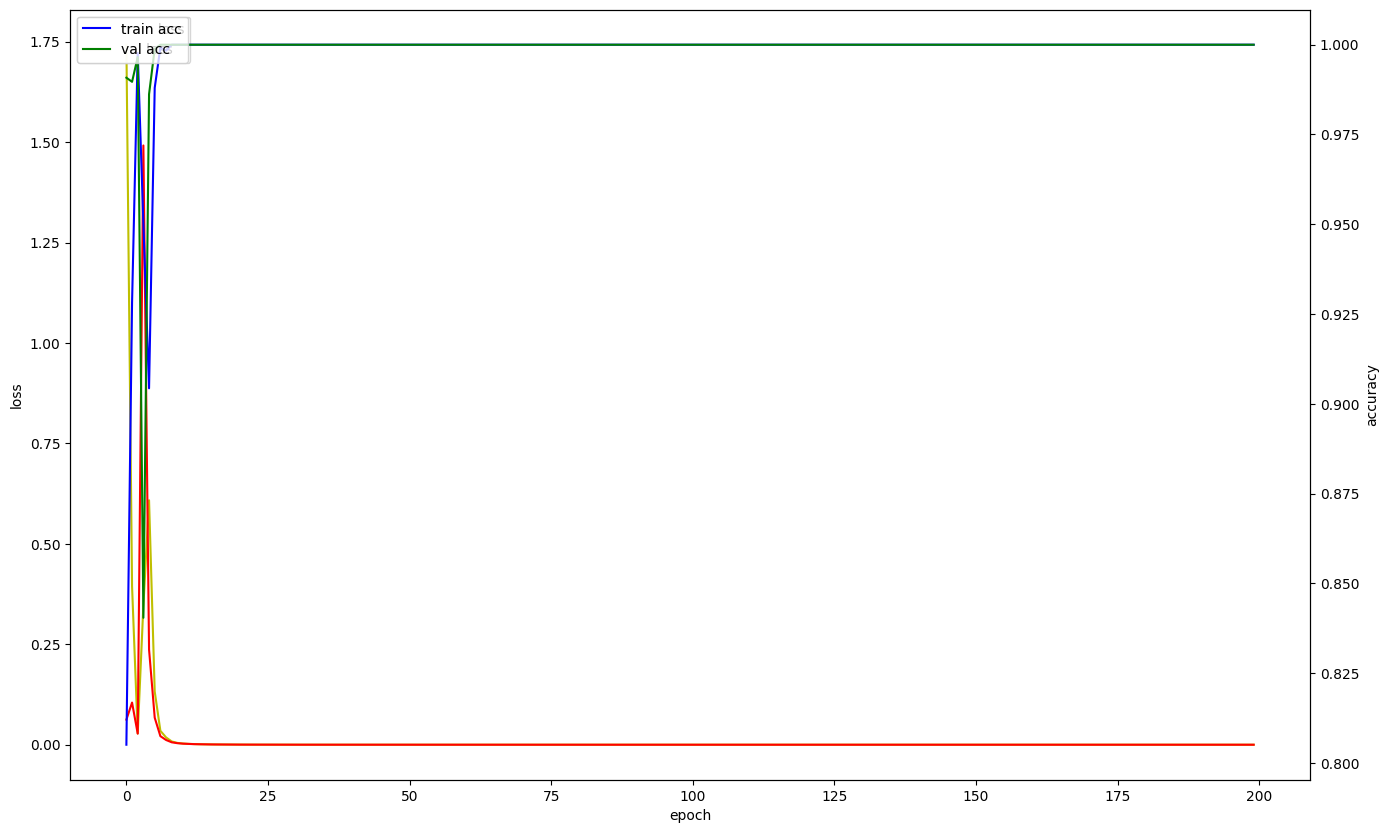

In [30]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

## 기능 개발

In [20]:
import cv2
import mediapipe as mp
import numpy as np
import time
from tensorflow.keras.models import load_model

In [21]:
actions = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
model = load_model('./model/model.h5')
passward = []

# 초기화
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 1, # 몇 개의 손을 인식할 것인지
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)

### 비밀번호 세팅 함수

In [34]:
def set_PassWard(actions = actions, model = model,
                 mp_hands = mp_hands, mp_drawing = mp_drawing, hands = hands,
                 seq_length = 30, secs_for_action = 10):
    
    set_passward = ["_", "_", "_", "_"]
    # 웹캠 열기
    cap = cv2.VideoCapture(0)

    created_time = int(time.time())
    seq = []
    action_seq = []
    order = ['first', 'second', 'third', 'fourth']

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_file = cv2.VideoWriter('./data/image/save_HW.mp4', fourcc, 20.0, (640, 480))

    # 웹캠을 열어서 데이터 모으기
    while cap.isOpened():
        for idx, action in enumerate(order):

            # 이미지 읽기
            ret, img = cap.read()

            # flip, 웹캠 이미지가 거울처럼 나타나기 때문
            img = cv2.flip(img, 1)

            # 어떤 제스쳐를 학습시킬 것인지 표시
            cv2.putText(img, f'Waiting for collecting {action.upper()} passward...', org=(10,30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=2)
            
            #3초동안 대기
            cv2.imshow('img', img)
            cv2.waitKey(3000)
            
            start_time = time.time()

            #10초동안 촬영
            while time.time() - start_time < secs_for_action:
                ret, img = cap.read()

                img = cv2.flip(img, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 기본적으로 BGR로 영상을 읽기 때문에 RGB로 바꿔야 함
                result = hands.process(img) # RGB로 바꾼 데이터를 result에 저장
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                if result.multi_hand_landmarks is not None:
                    for res in result.multi_hand_landmarks:
                        joint = np.zeros((21,4))
                        for j, lm in enumerate(res.landmark):
                            joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                        # 점들 간의 각도 계산하기
                        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                        v = v2 - v1 # v2와 v1 사이의 벡터 구하기

                        # 점곱을 구한 다음 arccos으로 각도 구하기
                        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                        # Get angle using arcos of dot product
                        angle = np.arccos(np.einsum('nt,nt->n',
                            v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                        angle = np.degrees(angle) # 라디안을 각도로 바꾸기

                        d = np.concatenate([joint.flatten(), angle])


                        seq.append(d)

                        mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

                        if len(seq) < seq_length:
                            continue
                        
                        input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

                        # 모델 예측
                        y_pred = model.predict(input_data).squeeze()

                        # 예측한 값의 인덱스 구하기
                        i_pred = int(np.argmax(y_pred))
                        conf = y_pred[i_pred]

                        # confidence가 0.9보다 작으면
                        if conf < 0.9:
                            continue # 제스쳐 인식 못 한 상황으로 판단
                        
                        action = actions[i_pred]
                        action_seq.append(action) # action_seq에 action을 저장
                        #print(action_seq)
                                # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
                        if len(action_seq) < 3:
                            continue
                        # 제스쳐 판단 불가이면 this_action은 ?
                        this_action = '?'
                        # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
                        if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                            this_action = action
                        # 텍스트 출력
                        cv2.putText(img, f'{this_action}', org=(int(res.landmark[0].x * img.shape[1]), 
                                                                int(res.landmark[0].y * img.shape[0] + 20)), 
                                                                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                                                                color=(255, 255, 255), thickness=2)
                        
                        set_passward[idx] = this_action

                    cv2.putText(img, f'PassWard {set_passward} is saved', org=(50,50),
                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                                    color=(255, 255, 255), thickness=2)

                    cv2.imshow('img', img)

                    # 동영상 파일에 프레임을 저장한다
                    output_file.write(img)
                    
                    if cv2.waitKey(1) == ord('q'):
                        break
        break
    cap.release()
    output_file.release()

    cv2.destroyAllWindows()

    return set_passward

### 비밀번호 비교 함수

In [35]:
def compare_PassWard(set_passward, actions = actions, model = model,
                 mp_hands = mp_hands, mp_drawing = mp_drawing, hands = hands,
                 seq_length = 30, secs_for_action = 10):

    input_passward = ['*', '*', '*', '*']

    # 웹캠 열기
    cap = cv2.VideoCapture(0)

    created_time = int(time.time())
    seq = []
    action_seq = []
    order = ['first', 'second', 'third', 'fourth']

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_file = cv2.VideoWriter('./data/image/compare_HW.mp4', fourcc, 20.0, (640, 480))

    # 웹캠을 열어서 데이터 모으기
    while cap.isOpened():
        for idx, action in enumerate(order):

            # 이미지 읽기
            ret, img = cap.read()

            # flip, 웹캠 이미지가 거울처럼 나타나기 때문
            img = cv2.flip(img, 1)

            # 어떤 제스쳐를 학습시킬 것인지 표시
            cv2.putText(img, f'Waiting for  {action.upper()} input passward...', org=(10,30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=2)
            
            #3초동안 대기
            cv2.imshow('img', img)
            cv2.waitKey(3000)
            
            start_time = time.time()
            #30초동안 촬영
            while time.time() - start_time < secs_for_action:
                ret, img = cap.read()

                img = cv2.flip(img, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 기본적으로 BGR로 영상을 읽기 때문에 RGB로 바꿔야 함
                result = hands.process(img) # RGB로 바꾼 데이터를 result에 저장
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                if result.multi_hand_landmarks is not None:
                    for res in result.multi_hand_landmarks:
                        joint = np.zeros((21,4))
                        for j, lm in enumerate(res.landmark):
                            joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                        # 점들 간의 각도 계산하기
                        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                        v = v2 - v1 # v2와 v1 사이의 벡터 구하기

                        # 점곱을 구한 다음 arccos으로 각도 구하기
                        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                        # Get angle using arcos of dot product
                        angle = np.arccos(np.einsum('nt,nt->n',
                            v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                        angle = np.degrees(angle) # 라디안을 각도로 바꾸기

                        d = np.concatenate([joint.flatten(), angle])


                        seq.append(d)

                        mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

                        if len(seq) < seq_length:
                            continue
                            
                        input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

                        # 모델 예측
                        y_pred = model.predict(input_data).squeeze()

                        # 예측한 값의 인덱스 구하기
                        i_pred = int(np.argmax(y_pred))
                        conf = y_pred[i_pred]

                        # confidence가 0.9보다 작으면
                        if conf < 0.9:
                            continue # 제스쳐 인식 못 한 상황으로 판단
                            
                        action = actions[i_pred]
                        action_seq.append(action) # action_seq에 action을 저장
                        #print(action_seq)
                                # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
                        if len(action_seq) < 3:
                            continue
                        # 제스쳐 판단 불가이면 this_action은 ?
                        this_action = '?'
                        # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
                        if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                            this_action = action

                        
                        # 텍스트 출력
                        cv2.putText(img, f'{this_action}', org=(int(res.landmark[0].x * img.shape[1]), 
                                                                int(res.landmark[0].y * img.shape[0] + 20)), 
                                                                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                                                                color=(255, 255, 255), thickness=2)
                            
                        input_passward[idx] = this_action

                    if (input_passward[0] == set_passward[0]) and \
                        (input_passward[1] == set_passward[1]) and \
                            (input_passward[2] == set_passward[2]) and \
                                (input_passward[3] == set_passward[3]):                            
                        cv2.putText(img, f'{input_passward} is correct', org=(50,50),
                                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                                        color=(255, 255, 255), thickness=2)
                            
                        compared_value = 1
                        
                    else :
                        cv2.putText(img, f'{input_passward} does not match.', org=(50,50),
                                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                                        color=(255, 255, 255), thickness=2)
                        
                        compared_value = 0

                    cv2.imshow('img', img)

                    # 동영상 파일에 프레임을 저장한다
                    output_file.write(img)

                    if cv2.waitKey(1) == ord('q'):
                        break
        break
        
    cap.release()
    output_file.release()

    cv2.destroyAllWindows()

    return (input_passward, compared_value)

In [36]:
set_passward = set_PassWard()
set_passward

1/1 [==============================] - 0s 13ms/step


['0', '7', '1', '4']

In [37]:
input_PW, result = compare_PassWard(set_passward)

print(f"입력된 비밀번호 : {input_PW}")

if result == 1:
    print("비밀번호가 일치 합니다. 문이 열립니다.")

else :
    print("비밀번호가 일치하지 않습니다. 다시 한번 확인해 주세요")

1/1 [==============================] - 0s 13ms/step
입력된 비밀번호 : ['0', '7', '1', '4']
비밀번호가 일치 합니다. 문이 열립니다.
